## Spooky Author Identification

In [54]:
import numpy as np
import pandas as pd
import xgboost as xgb
from tqdm import tqdm, tqdm_notebook
from sklearn.svm import SVC
from keras.layers import  Conv1D,GlobalMaxPooling1D, MaxPooling1D
from keras.models import Sequential
##from keras.models.pooling  import 
from keras.layers import Flatten, Bidirectional, SpatialDropout1D
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import gc

import string
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline



In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df_train   = pd.read_csv('train.csv')
df_test    = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [4]:
df_train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
submission.head()

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698


In [6]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps) ## so that we never take log of zero
    n = actual.shape[0] ##no of examples 
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / n * vsota

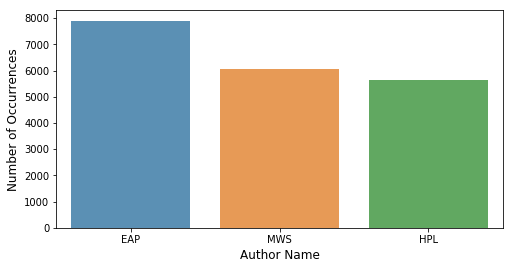

In [17]:
cnt_srs = df_train['author'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

In [7]:
## convert text labels to integers, 0, 1 2

In [8]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(df_train['author'].values)

In [9]:
##Data is not balanced

In [10]:
print(y[y==0].shape)
print(y[y==1].shape)
print(y[y==2].shape)

(7900,)
(5635,)
(6044,)


In [11]:
seed =1987
X_train, X_valid, y_train,y_valid = train_test_split(df_train['text'], y,
                                                   stratify = y, test_size = 0.1,shuffle= True,
                                                   random_state = seed)

In [12]:
print(y_train[y_train==0].shape)
print(y_train[y_train==1].shape)
print(y_train[y_train==2].shape)

(7110,)
(5071,)
(5440,)


In [13]:
X_train.shape
y_train.shape

(17621,)

In [25]:
tfv = TfidfVectorizer(min_df = 5, max_features = None, strip_accents = 'unicode', analyzer = 'word', 
                      token_pattern= r'\w{1,}', ngram_range= (1,3), use_idf = True, smooth_idf = True, 
                     sublinear_tf = True , stop_words = 'english')


In [26]:
gc.collect()

0

In [28]:
tfv.fit(X_train)
X_train_tfv = tfv.transform(X_train)
X_valid_tfv = tfv.transform(X_valid)

In [31]:
## Logistic on tfidf
clf = LogisticRegression(C= 1.0)
clf.fit(X_train_tfv, y_train)
predictions = clf.predict_proba(X_valid_tfv)

print('TFIDF Loss', multiclass_logloss(y_valid, predictions))

TFIDF Loss 0.6298162023590189


In [36]:
prediction_class = clf.predict(X_valid_tfv)

confusion = confusion_matrix(y_valid,prediction_class,labels = [0,1,2])

confusion = pd.DataFrame(confusion, index=['True 0', 'True 1','True 2'],
                         columns=['Pred 0','Pred 1', 'Pred 2'])
print(confusion)

        Pred 0  Pred 1  Pred 2
True 0     655      70      65
True 1     101     423      40
True 2     109      33     462


In [37]:
## Logistic on countvectorizer
ctv = CountVectorizer(analyzer = 'word',token_pattern= r'\w{1,}',ngram_range = (1,3), stop_words = 'english' )
ctv.fit(X_train)
X_train_ctv = ctv.transform(X_train)
X_valid_ctv = ctv.transform(X_valid)

In [42]:
clf = LogisticRegression(C= 1.0)
clf.fit(X_train_ctv, y_train)
predictions = clf.predict_proba(X_valid_ctv)

print('Count Vectorizer Loss', multiclass_logloss(y_valid, predictions))
print('\n')
####
prediction_class = clf.predict(X_valid_ctv)

confusion = confusion_matrix(y_valid,prediction_class,labels = [0,1,2])

confusion = pd.DataFrame(confusion, index=['True 0', 'True 1','True 2'],
                         columns=['Pred 0','Pred 1', 'Pred 2'])
print(confusion)

Count Vectorizer Loss 0.5362277258308014


        Pred 0  Pred 1  Pred 2
True 0     678      54      58
True 1     118     401      45
True 2     119      28     457


In [44]:
# simple Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(X_train_tfv, y_train)
predictions = clf.predict_proba(X_valid_tfv)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, predictions))

logloss: 0.590 


In [45]:
# simple Naive Bayes on CountVectorizer
clf = MultinomialNB()
clf.fit(X_train_ctv, y_train)
predictions = clf.predict_proba(X_valid_ctv)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, predictions))

logloss: 0.468 


In [48]:
## Reduce the number of features of TDIDF using SVD before fitting to SVM

## Reduce the number of component chosen is 150 (120-200 range)

svd = decomposition.TruncatedSVD(n_components = 150)
svd.fit(X_train_tfv)
X_train_svd = svd.transform(X_train_tfv)
X_valid_svd = svd.transform(X_valid_tfv)

####
# Scale the data obtained from SVD.
scl = preprocessing.StandardScaler()
scl.fit(X_train_svd)
X_train_svd_scl = scl.transform(X_train_svd)
X_valid_svd_scl = scl.transform(X_valid_svd)
####
## simple SVM
clf = SVC(C =1.0, probability = True)
clf.fit(X_train_svd_scl, y_train)
predictions = clf.predict_proba(X_valid_svd_scl)
print ("logloss: %0.3f " % multiclass_logloss(y_valid, predictions))

logloss: 0.745 


In [51]:
## Using the TDIDF itself to reduce the number of features
## This performed worse

tfv1 = TfidfVectorizer(min_df = 3, max_features = 150, strip_accents = 'unicode', analyzer = 'word', 
                      token_pattern= r'\w{1,}', ngram_range= (1,3), use_idf = True, smooth_idf = True, 
                     sublinear_tf = True , stop_words = 'english')

tfv1.fit(X_train)
X_train_tfv1 = tfv1.transform(X_train)
X_valid_tfv1 = tfv1.transform(X_valid)

## simple SVM
clf = SVC(C =1.0, probability = True)
clf.fit(X_train_tfv1, y_train)
predictions = clf.predict_proba(X_valid_tfv1)
print ("logloss: %0.3f " % multiclass_logloss(y_valid, predictions))

logloss: 0.984 


In [54]:
## simple xgboost on tf-idf

clf = xgb.XGBClassifier(max_depth = 7, n_estimators = 200, colsample_bytree =0.8,
                       subsample = 0.8, nthread = 10, learning_rate = 0.1)

clf.fit(X_train_tfv.tocsc(),y_train) ##Convert this matrix to Compressed Sparse Column format.
predictions = clf.predict_proba(X_valid_tfv.tocsc())
print ("logloss: %0.3f " % multiclass_logloss(y_valid, predictions))

logloss: 0.777 


In [55]:
## simple xgboost on countvectorizer

clf = xgb.XGBClassifier(max_depth = 7, n_estimators = 200, colsample_bytree =0.8,
                       subsample = 0.8, nthread = 10, learning_rate = 0.1)

clf.fit(X_train_ctv.tocsc(),y_train) ##Convert this matrix to Compressed Sparse Column format.
predictions = clf.predict_proba(X_valid_ctv.tocsc())
print ("logloss: %0.3f " % multiclass_logloss(y_valid, predictions))

logloss: 0.773 


In [58]:
##xgboost on tf-idf svd features

clf = xgb.XGBClassifier(thread = 10)

clf.fit(X_train_svd,y_train) ##Convert this matrix to Compressed Sparse Column format.
predictions = clf.predict_proba(X_valid_svd)
print ("logloss: %0.3f " % multiclass_logloss(y_valid, predictions))

logloss: 0.831 


In [59]:
scorer_func = metrics.make_scorer(multiclass_logloss, greater_is_better = False, needs_proba = True)

In [67]:
## 

svd = TruncatedSVD()
##
scl = preprocessing.StandardScaler()
##
logistic_model = LogisticRegression()

clf = pipeline.Pipeline([('svd', svd), ('scl', scl), ('lr', logistic_model)])


In [70]:
param_grid = {'svd__n_components': [120,150,180],
              'lr__C': [0.1,1.0,10],
              'lr__penalty': ['l1','l2']}

In [75]:
##Grid Search Model

model = GridSearchCV(estimator = clf, param_grid=param_grid, scoring = scorer_func, n_jobs = -1, 
                     iid= True, refit = True,cv =2)

model.fit(X_train_tfv, y_train)
print("Best score: %0.3f" % model.best_score_)

best_parameters = model.best_estimator_.get_params()
print("Best parameters set:", best_parameters)

Best score: -0.739
Best parameters set: {'memory': None, 'steps': [('svd', TruncatedSVD(algorithm='randomized', n_components=180, n_iter=5,
       random_state=None, tol=0.0)), ('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lr', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))], 'svd': TruncatedSVD(algorithm='randomized', n_components=180, n_iter=5,
       random_state=None, tol=0.0), 'scl': StandardScaler(copy=True, with_mean=True, with_std=True), 'lr': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False), 'svd__algorithm': 'randomized', 'svd__

In [76]:
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

	lr__C: 0.1
	lr__penalty: 'l2'
	svd__n_components: 180


In [78]:
nb_model = MultinomialNB()

# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])

# parameter grid
param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scorer_func,
                                 n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model
model.fit(X_train_tfv, y_train)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: -0.505
Best parameters set:
	nb__alpha: 0.1


In [79]:
nb_model = MultinomialNB()

# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])

# parameter grid
param_grid = {'nb__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scorer_func,
                                 n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model 
model.fit(X_train_ctv, y_train)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: -0.501
Best parameters set:
	nb__alpha: 1


In [81]:
### More Finetuning

In [90]:
nb_model = MultinomialNB()

# Create the pipeline 
clf = pipeline.Pipeline([('nb', nb_model)])

# parameter grid
param_grid = {'nb__alpha': [0.8, 1,1.5,1.6,1.7,1.75,1.8,1.9,2,2.5]}  

# Initialize Grid Search Model
model = GridSearchCV(estimator=clf, param_grid=param_grid, scoring=scorer_func,
                                 n_jobs=-1, iid=True, refit=True, cv=2)

# Fit Grid Search Model 
model.fit(X_train_ctv, y_train)  # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()
for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: -0.493
Best parameters set:
	nb__alpha: 1.7


In [116]:
count = len(open('glove.840B.300d.txt', encoding='utf-8').readlines(  ))
count

2196017

In [118]:
def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

In [120]:
## # load the GloVe 300D vectors in a dictionary:

embedding_index = {}

with open('glove.840B.300d.txt', encoding='utf-8') as f:
    for line in tqdm_notebook(f,total=2196017):
        value = line.split()
        word = value[0]
        ##print(value)
        i = 1
        while not isfloat(value[i]):
            word = word + ' ' + value[i]
            i = i + 1
        if i > 1:
            print('Exceptional case: {0}'.format(word))
        coefs = np.asarray(value[i:], dtype='float32')
        embedding_index[word] = coefs
        ##break
print(len(embedding_index), 'word vectors found in globe')

Exceptional case: . . .
Exceptional case: at name@domain.com
Exceptional case: . . . . .
Exceptional case: to name@domain.com
Exceptional case: . .
Exceptional case: . . . .
Exceptional case: email name@domain.com
Exceptional case: or name@domain.com
Exceptional case: contact name@domain.com
Exceptional case: Email name@domain.com
Exceptional case: on name@domain.com
Exceptional case: At Killerseats.com
Exceptional case: by name@domain.com
Exceptional case: in mylot.com
Exceptional case: emailing name@domain.com
Exceptional case: Contact name@domain.com
Exceptional case: at name@domain.com
Exceptional case: • name@domain.com
Exceptional case: at Amazon.com
Exceptional case: is name@domain.com
2195903 word vectors found in globe


In [137]:
## creates a normalized vector for the whole sentence

def sent2vec(s):
    ##words = str(s).lower().decode('utf-8')
    words = str(s).lower()
    words = word_tokenize(words)
    words = [word for word in words if word not in stop_words]
    words = [word for word in words if word.isalpha()]
    
    vector = []
    for word in words:
        try:
            vector.append(embedding_index[word])
        except:
            continue
    vector = np.array(vector)
    
    v = vector.sum(axis =0)## reduce the dimension  ## may use squeeze
    ##print(type(v))
    if type(v) != np.ndarray:
        return  np.zeros(300)
    return v/np.sqrt((v**2).sum())

In [139]:
# create sentence vectors

X_train_glove = [sent2vec(s) for s in tqdm_notebook(X_train, total= len(X_train))]
X_valid_glove = [sent2vec(s) for s in tqdm_notebook(X_valid, total= len(X_valid))]

In [140]:
X_train_glove = np.array(X_train_glove)
X_valid_glove = np.array(X_valid_glove)

In [144]:
##simple xgboost on glove features
clf = xgb.XGBClassifier(nthread=10)
clf.fit(X_train_glove, y_train)
predictions = clf.predict_proba(X_valid_glove)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, predictions))

logloss: 1.066 


In [146]:
##simple xgboost on glove features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)

clf.fit(X_train_glove, y_train)
predictions = clf.predict_proba(X_valid_glove)

print ("logloss: %0.3f " % multiclass_logloss(y_valid, predictions))

logloss: 1.069 


In [147]:
#### LSTM and GRU

In [148]:
# scale the data before any neural net:

scl = preprocessing.StandardScaler()
X_train_glove_scl = scl.fit_transform(X_train_glove)
X_valid_glove_scl = scl.transform(X_valid_glove)

In [149]:
# we need to binarize the labels for the neural net
y_train_enc = np_utils.to_categorical(y_train)
y_valid_enc = np_utils.to_categorical(y_valid)

In [154]:
print(y_train)
print('\n')
print(y_train_enc)

[2 2 0 ... 2 2 0]


[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [155]:
# create a simple 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=300, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(3))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [156]:
model.fit(X_train_glove_scl, y=y_train_enc, batch_size=64, 
          epochs=5, verbose=2, 
          validation_data=(X_valid_glove_scl, y_valid_enc))

Train on 17621 samples, validate on 1958 samples
Epoch 1/5
 - 15s - loss: 1.2840 - val_loss: 1.1076
Epoch 2/5
 - 5s - loss: 1.1456 - val_loss: 1.0887
Epoch 3/5
 - 4s - loss: 1.1092 - val_loss: 1.0880
Epoch 4/5
 - 4s - loss: 1.1010 - val_loss: 1.0898
Epoch 5/5
 - 4s - loss: 1.1004 - val_loss: 1.0904


In [165]:
##using keras
max_len = 70

token = text.Tokenizer(num_words = None)
token.fit_on_texts(X_train)
X_train_seq = token.texts_to_sequences(X_train)
X_valid_seq = token.texts_to_sequences(X_valid)
##
X_train_pad = sequence.pad_sequences(X_train_seq,maxlen= max_len)
X_valid_pad = sequence.pad_sequences(X_valid_seq,maxlen= max_len)

word_index = token.word_index

In [168]:
# create an embedding matrix for the words we have in the dataset

embedding_matrix = np.zeros((len(word_index) + 1, 300))

for words, index in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [170]:
##simple LSTM with glove embeddings and two dense layers

model = Sequential()
model.add(Embedding(len(word_index)+1,300,weights=[embedding_matrix],
                   input_length=max_len,trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')



In [173]:
model.fit(X_train_pad, y=y_train_enc, batch_size=512, epochs=100, verbose=2, validation_data=(X_valid_pad, y_valid_enc))

Train on 17621 samples, validate on 1958 samples
Epoch 1/100
 - 6s - loss: 1.1099 - val_loss: 1.0901
Epoch 2/100
 - 4s - loss: 1.0912 - val_loss: 1.0894
Epoch 3/100
 - 4s - loss: 1.0900 - val_loss: 1.0880
Epoch 4/100
 - 4s - loss: 1.0892 - val_loss: 1.0880
Epoch 5/100
 - 5s - loss: 1.0900 - val_loss: 1.0879
Epoch 6/100
 - 5s - loss: 1.0892 - val_loss: 1.0883
Epoch 7/100
 - 5s - loss: 1.0886 - val_loss: 1.0878
Epoch 8/100
 - 5s - loss: 1.0881 - val_loss: 1.0875
Epoch 9/100
 - 4s - loss: 1.0887 - val_loss: 1.0877
Epoch 10/100
 - 4s - loss: 1.0883 - val_loss: 1.0876
Epoch 11/100
 - 5s - loss: 1.0889 - val_loss: 1.0879
Epoch 12/100
 - 5s - loss: 1.0886 - val_loss: 1.0879
Epoch 13/100
 - 4s - loss: 1.0884 - val_loss: 1.0876
Epoch 14/100
 - 4s - loss: 1.0882 - val_loss: 1.0877
Epoch 15/100
 - 4s - loss: 1.0882 - val_loss: 1.0878
Epoch 16/100
 - 4s - loss: 1.0879 - val_loss: 1.0875
Epoch 17/100
 - 4s - loss: 1.0882 - val_loss: 1.0876
Epoch 18/100
 - 4s - loss: 1.0884 - val_loss: 1.0876
Epoch 

In [175]:
# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

model.fit(X_train_pad, y=y_train_enc, batch_size=512, epochs=100, 
          verbose=2, validation_data=(X_valid_pad, y_valid_enc), callbacks=[earlystop])

Train on 17621 samples, validate on 1958 samples
Epoch 1/100
 - 5s - loss: 1.0760 - val_loss: 1.0767
Epoch 2/100
 - 5s - loss: 1.0773 - val_loss: 1.0750
Epoch 3/100
 - 5s - loss: 1.0758 - val_loss: 1.0732
Epoch 4/100
 - 4s - loss: 1.0769 - val_loss: 1.0752
Epoch 5/100
 - 4s - loss: 1.0760 - val_loss: 1.0751
Epoch 6/100
 - 5s - loss: 1.0757 - val_loss: 1.0737


In [178]:
# simple bidirectional LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=2, mode='auto')
model.fit(X_train_pad, y=y_train_enc, batch_size=512, epochs=100, 
          verbose=2, validation_data=(X_valid_pad, y_valid_enc), callbacks=[earlystop])


Train on 17621 samples, validate on 1958 samples
Epoch 1/100
 - 15s - loss: 1.1183 - val_loss: 1.0892
Epoch 2/100
 - 12s - loss: 1.0947 - val_loss: 1.0868
Epoch 3/100
 - 12s - loss: 1.0910 - val_loss: 1.0862
Epoch 4/100
 - 12s - loss: 1.0907 - val_loss: 1.0883
Epoch 5/100
 - 12s - loss: 1.0893 - val_loss: 1.0868
Epoch 6/100
 - 12s - loss: 1.0894 - val_loss: 1.0869
Epoch 00006: early stopping


In [180]:
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences=True))
model.add(GRU(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=2, mode='auto')
model.fit(X_train_pad, y=y_train_enc, batch_size=512, epochs=100, 
          verbose=2, validation_data=(X_valid_pad, y_valid_enc), callbacks=[earlystop])

Train on 17621 samples, validate on 1958 samples
Epoch 1/100
 - 15s - loss: 1.1621 - val_loss: 1.0924
Epoch 2/100
 - 12s - loss: 1.1069 - val_loss: 1.0907
Epoch 3/100
 - 12s - loss: 1.1018 - val_loss: 1.0902
Epoch 4/100
 - 12s - loss: 1.0944 - val_loss: 1.0900
Epoch 5/100
 - 12s - loss: 1.0924 - val_loss: 1.0900
Epoch 6/100
 - 12s - loss: 1.0916 - val_loss: 1.0885
Epoch 7/100
 - 12s - loss: 1.0916 - val_loss: 1.0888
Epoch 8/100
 - 12s - loss: 1.0907 - val_loss: 1.0885
Epoch 9/100
 - 12s - loss: 1.0894 - val_loss: 1.0878
Epoch 10/100
 - 12s - loss: 1.0884 - val_loss: 1.0876
Epoch 11/100
 - 12s - loss: 1.0887 - val_loss: 1.0876
Epoch 12/100
 - 12s - loss: 1.0880 - val_loss: 1.0876
Epoch 13/100
 - 12s - loss: 1.0881 - val_loss: 1.0875
Epoch 14/100
 - 12s - loss: 1.0881 - val_loss: 1.0875
Epoch 15/100
 - 12s - loss: 1.0878 - val_loss: 1.0876
Epoch 16/100
 - 12s - loss: 1.0881 - val_loss: 1.0876
Epoch 00016: early stopping


In [181]:
## Ensembling

In [182]:
# this is the main ensembling class. 

import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
import pandas as pd
import os
import sys
import logging

logging.basicConfig(
    level=logging.DEBUG,
    format="[%(asctime)s] %(levelname)s %(message)s",
    datefmt="%H:%M:%S", stream=sys.stdout)
logger = logging.getLogger(__name__)


class Ensembler(object):
    def __init__(self, model_dict, num_folds=3, task_type='classification', optimize=roc_auc_score,
                 lower_is_better=False, save_path=None):
        """
        Ensembler init function
        :param model_dict: model dictionary, see README for its format
        :param num_folds: the number of folds for ensembling
        :param task_type: classification or regression
        :param optimize: the function to optimize for, e.g. AUC, logloss, etc. Must have two arguments y_test and y_pred
        :param lower_is_better: is lower value of optimization function better or higher
        :param save_path: path to which model pickles will be dumped to along with generated predictions, or None
        """

        self.model_dict = model_dict
        self.levels = len(self.model_dict)
        self.num_folds = num_folds
        self.task_type = task_type
        self.optimize = optimize
        self.lower_is_better = lower_is_better
        self.save_path = save_path

        self.training_data = None
        self.test_data = None
        self.y = None
        self.lbl_enc = None
        self.y_enc = None
        self.train_prediction_dict = None
        self.test_prediction_dict = None
        self.num_classes = None

    def fit(self, training_data, y, lentrain):
        """
        :param training_data: training data in tabular format
        :param y: binary, multi-class or regression
        :return: chain of models to be used in prediction
        """

        self.training_data = training_data
        self.y = y

        if self.task_type == 'classification':
            self.num_classes = len(np.unique(self.y))
            logger.info("Found %d classes", self.num_classes)
            self.lbl_enc = LabelEncoder()
            self.y_enc = self.lbl_enc.fit_transform(self.y)
            kf = StratifiedKFold(n_splits=self.num_folds)
            train_prediction_shape = (lentrain, self.num_classes)
        else:
            self.num_classes = -1
            self.y_enc = self.y
            kf = KFold(n_splits=self.num_folds)
            train_prediction_shape = (lentrain, 1)

        self.train_prediction_dict = {}
        for level in range(self.levels):
            self.train_prediction_dict[level] = np.zeros((train_prediction_shape[0],
                                                          train_prediction_shape[1] * len(self.model_dict[level])))

        for level in range(self.levels):

            if level == 0:
                temp_train = self.training_data
            else:
                temp_train = self.train_prediction_dict[level - 1]

            for model_num, model in enumerate(self.model_dict[level]):
                validation_scores = []
                foldnum = 1
                for train_index, valid_index in kf.split(self.train_prediction_dict[0], self.y_enc):
                    logger.info("Training Level %d Fold # %d. Model # %d", level, foldnum, model_num)

                    if level != 0:
                        l_training_data = temp_train[train_index]
                        l_validation_data = temp_train[valid_index]
                        model.fit(l_training_data, self.y_enc[train_index])
                    else:
                        l0_training_data = temp_train[0][model_num]
                        if type(l0_training_data) == list:
                            l_training_data = [x[train_index] for x in l0_training_data]
                            l_validation_data = [x[valid_index] for x in l0_training_data]
                        else:
                            l_training_data = l0_training_data[train_index]
                            l_validation_data = l0_training_data[valid_index]
                        model.fit(l_training_data, self.y_enc[train_index])

                    logger.info("Predicting Level %d. Fold # %d. Model # %d", level, foldnum, model_num)

                    if self.task_type == 'classification':
                        temp_train_predictions = model.predict_proba(l_validation_data)
                        self.train_prediction_dict[level][valid_index,
                        (model_num * self.num_classes):(model_num * self.num_classes) +
                                                       self.num_classes] = temp_train_predictions

                    else:
                        temp_train_predictions = model.predict(l_validation_data)
                        self.train_prediction_dict[level][valid_index, model_num] = temp_train_predictions
                    validation_score = self.optimize(self.y_enc[valid_index], temp_train_predictions)
                    validation_scores.append(validation_score)
                    logger.info("Level %d. Fold # %d. Model # %d. Validation Score = %f", level, foldnum, model_num,
                                validation_score)
                    foldnum += 1
                avg_score = np.mean(validation_scores)
                std_score = np.std(validation_scores)
                logger.info("Level %d. Model # %d. Mean Score = %f. Std Dev = %f", level, model_num,
                            avg_score, std_score)

            logger.info("Saving predictions for level # %d", level)
            train_predictions_df = pd.DataFrame(self.train_prediction_dict[level])
            train_predictions_df.to_csv(os.path.join(self.save_path, "train_predictions_level_" + str(level) + ".csv"),
                                        index=False, header=None)

        return self.train_prediction_dict

    def predict(self, test_data, lentest):
        self.test_data = test_data
        if self.task_type == 'classification':
            test_prediction_shape = (lentest, self.num_classes)
        else:
            test_prediction_shape = (lentest, 1)

        self.test_prediction_dict = {}
        for level in range(self.levels):
            self.test_prediction_dict[level] = np.zeros((test_prediction_shape[0],
                                                         test_prediction_shape[1] * len(self.model_dict[level])))
        self.test_data = test_data
        for level in range(self.levels):
            if level == 0:
                temp_train = self.training_data
                temp_test = self.test_data
            else:
                temp_train = self.train_prediction_dict[level - 1]
                temp_test = self.test_prediction_dict[level - 1]

            for model_num, model in enumerate(self.model_dict[level]):

                logger.info("Training Fulldata Level %d. Model # %d", level, model_num)
                if level == 0:
                    model.fit(temp_train[0][model_num], self.y_enc)
                else:
                    model.fit(temp_train, self.y_enc)

                logger.info("Predicting Test Level %d. Model # %d", level, model_num)

                if self.task_type == 'classification':
                    if level == 0:
                        temp_test_predictions = model.predict_proba(temp_test[0][model_num])
                    else:
                        temp_test_predictions = model.predict_proba(temp_test)
                    self.test_prediction_dict[level][:, (model_num * self.num_classes): (model_num * self.num_classes) +
                                                                                        self.num_classes] = temp_test_predictions

                else:
                    if level == 0:
                        temp_test_predictions = model.predict(temp_test[0][model_num])
                    else:
                        temp_test_predictions = model.predict(temp_test)
                    self.test_prediction_dict[level][:, model_num] = temp_test_predictions

            test_predictions_df = pd.DataFrame(self.test_prediction_dict[level])
            test_predictions_df.to_csv(os.path.join(self.save_path, "test_predictions_level_" + str(level) + ".csv"),
                                       index=False, header=None)

        return self.test_prediction_dict
# specify the data to be used for every level of ensembling:
train_data_dict = {0: [X_train_tfv, X_train_ctv, X_train_tfv, X_train_ctv], 1: [X_train_glove]}
test_data_dict = {0: [X_valid_tfv, X_valid_ctv, X_valid_tfv, X_valid_ctv], 1: [X_valid_glove]}

model_dict = {0: [LogisticRegression(), LogisticRegression(), MultinomialNB(alpha=0.1), MultinomialNB()],

              1: [xgb.XGBClassifier(silent=True, n_estimators=120, max_depth=7)]}

#####################
ens = Ensembler(model_dict=model_dict, num_folds=3, task_type='classification',
                optimize=multiclass_logloss, lower_is_better=True, save_path='')

ens.fit(train_data_dict, y_train, lentrain=X_train_glove.shape[0])
preds = ens.predict(test_data_dict, lentest=X_valid_glove.shape[0])

[23:50:26] INFO Found 3 classes
[23:50:26] INFO Training Level 0 Fold # 1. Model # 0
[23:50:26] INFO Predicting Level 0. Fold # 1. Model # 0
[23:50:26] INFO Level 0. Fold # 1. Model # 0. Validation Score = 0.663318
[23:50:26] INFO Training Level 0 Fold # 2. Model # 0
[23:50:26] INFO Predicting Level 0. Fold # 2. Model # 0
[23:50:26] INFO Level 0. Fold # 2. Model # 0. Validation Score = 0.659648
[23:50:26] INFO Training Level 0 Fold # 3. Model # 0
[23:50:26] INFO Predicting Level 0. Fold # 3. Model # 0
[23:50:26] INFO Level 0. Fold # 3. Model # 0. Validation Score = 0.661545
[23:50:26] INFO Level 0. Model # 0. Mean Score = 0.661503. Std Dev = 0.001498
[23:50:26] INFO Training Level 0 Fold # 1. Model # 1
[23:50:27] INFO Predicting Level 0. Fold # 1. Model # 1
[23:50:27] INFO Level 0. Fold # 1. Model # 1. Validation Score = 0.569423
[23:50:27] INFO Training Level 0 Fold # 2. Model # 1
[23:50:28] INFO Predicting Level 0. Fold # 2. Model # 1
[23:50:28] INFO Level 0. Fold # 2. Model # 1. Val

In [184]:
# check for the valid error:
multiclass_logloss(y_valid, preds[1])

0.42454302013495454

#### Feature Engineering --Start

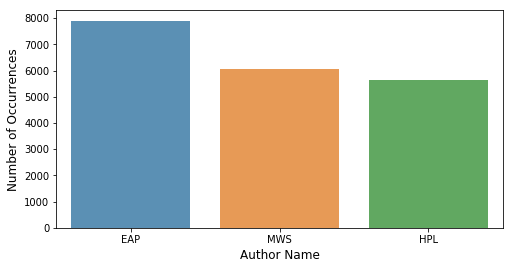

In [22]:
cnt_srs = df_train['author'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

In [23]:
##The Dataset is not balancd

In [25]:
df_train.columns

Index(['id', 'text', 'author'], dtype='object')

In [37]:
group_df = df_train.groupby('author')

for name, group in group_df:
    print(name)
    count =0
    for index,row in group.iterrows():
        print(row['text'])
        count +=1
        if count ==5:
            break
        print('\n')
    print('*************************************************************')

EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.


In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.


The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.


The surcingle hung in ribands from my body.


I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you could not a

Meta Features:
    
#Number of words in the text
#Number of unique words in the text
#Number of characters in the text
#Number of stopwords
#Number of punctuations
#Number of upper case words
#Number of title case words
#Average length of the words

In [47]:
type(df_train['author'])

pandas.core.series.Series

4

In [69]:
## Number of words in the text ##
df_train['num_words'] = df_train['text'].apply(lambda x : len(str(x).split()))
df_test["num_words"] = df_test["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
##pd.Series(str(x).split()).nunique() -- one way
df_train['num_unique_words'] = df_train['text'].apply(lambda x : len(set(str(x).split())))
df_test['num_unique_words'] = df_test['text'].apply(lambda x : len(set(str(x).split())))

# Number of characters in the text ##
df_train['num_chars'] = df_train['text'].apply(lambda x : len(str(x)))
df_test['num_chars'] = df_test['text'].apply(lambda x : len(str(x)))

## Number of stopwords in the text ##
df_train['num_stopwords'] = df_train['text'].apply(lambda x : len([word for word in str(x).lower().split() 
                                                                 if word in stop_words ]))
df_test['num_stopwords'] = df_test['text'].apply(lambda x : len([word for word in str(x).lower().split() 
                                                                 if word in stop_words ]))
## Number of punctuations in the text ##
df_train['num_punctuations'] = df_train['text'].apply(lambda x : len([c for c in str(x) if x in string.punctuation]))
df_test['num_punctuations'] = df_test['text'].apply(lambda x : len([c for c in str(x) if x in string.punctuation]))

## Number of title case words in the text ##
df_train['num_words_title'] = df_train['text'].apply(lambda x : len([word for word in str(x).split() 
                                                                     if word.istitle()]))
df_test['num_words_title'] = df_test['text'].apply(lambda x : len([word for word in str(x).split() 
                                                                     if word.istitle()]))

## Number of upper case words in the text ##
df_train['num_words_upper'] = df_train['text'].apply(lambda x : len([word for word in str(x).split() 
                                                                     if word.isupper()]))
df_test['num_words_upper'] = df_test['text'].apply(lambda x : len([word for word in str(x).split() 
                                                                     if word.isupper()]))

## Average length of the words in the text ##
df_train['mean_word_length'] = df_train['text'].apply(lambda x : np.mean([len(word) for word in str(x).split() ]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x : np.mean([len(word) for word in str(x).split() ]))
                                                                  

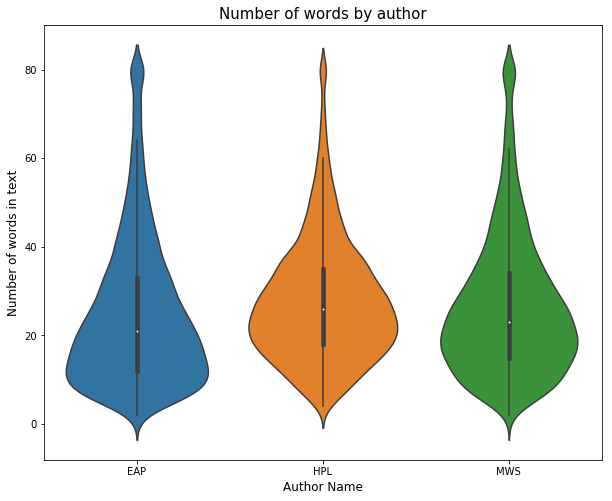

In [64]:
## For any row where num_words > 80 , set the num_words value to 80
df_train['num_words'].loc[df_train['num_words']>80] = 80###truncation for better visuals
plt.figure(figsize=(10,8))
sns.violinplot(x='author', y='num_words', data=df_train)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()

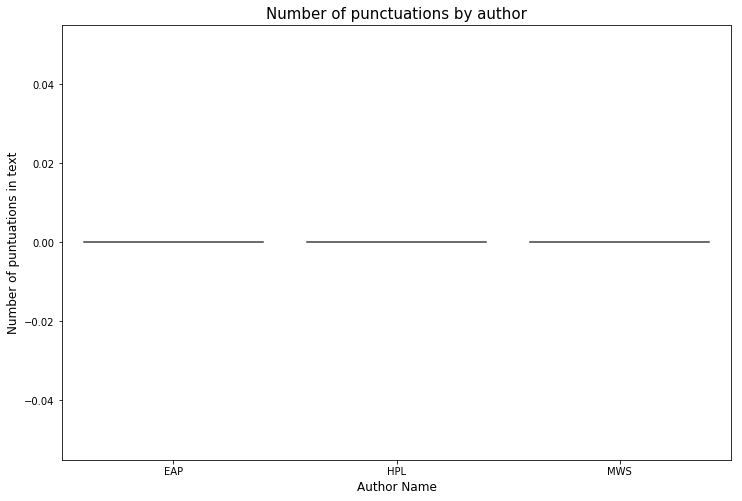

In [67]:
df_train['num_punctuations'].loc[df_train['num_punctuations']>10] = 10 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_punctuations', data=df_train)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of puntuations in text', fontsize=12)
plt.title("Number of punctuations by author", fontsize=15)
plt.show()

In [72]:
## Why is this zero. Because we removed the punctuations from the data using preprocessing

In [75]:
## Prepare the data for modeling ###
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
y_train = df_train['author'].map(author_mapping_dict) ## This words same as label encoder
train_id = df_train['id'].values
test_id = df_test['id'].values

### recompute the trauncated variables again ###
df_train["num_words"] = df_train["text"].apply(lambda x: len(str(x).split()))
df_test["num_words"] = df_test["text"].apply(lambda x: len(str(x).split()))
df_train["mean_word_len"] = df_train["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test["mean_word_len"] = df_test["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))


cols_to_drop = ['id', 'text']
train_X = df_train.drop(cols_to_drop+['author'], axis=1)
test_X = df_test.drop(cols_to_drop, axis=1)

In [76]:
##simple XGBoost model with these meta features alone.

In [77]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

In [ ]:
#For the sake of kernel run time, 
#we can just check the first fold in the k-fold cross validation for the scores. 
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

In [ ]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [ ]:
#Text Based Features :

#using tf-idf values of the words present in the text. 

### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
train_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist())
#train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

In [ ]:
#Now that we have got the tfidf vector, here is the tricky part. 
#The tfidf output is a sparse matrix and so if we have to use it 
#with other dense features, we have couple of choices.

##option 1

#1.We can choose to get the top 'n' features (depending on the system config) from the tfidf vectorizer, 
#convert it into dense format and concat with other features.

##option 2

#2.Build a model using just the sparse features and then use the predictions as one of the features 
#along with other dense features.

##Based on the dataset, one might perform better than the other. 

In [ ]:


def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [ ]:
##Ideally you would want to fit the tdidf using the ids selected by kFold.split

In [ ]:
##Naive Bayes on Word Tfidf Vectorizer:

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

In [ ]:
##SVD on word TFIDF:

n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(train_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
## Here I am merging the meta features and the SVD on TFIDF features
## Remember axis is 1 here.
##This is option1 that is mentioned above
train_df = pd.concat([train_df, train_svd], axis=1) 
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [ ]:
##Naive Bayes on Word Count Vectorizer:

### Fit transform the count vectorizer ###
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

#Now let us build Multinomial NB model using count vectorizer based features..
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([df_train.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
df_train["nb_cvec_eap"] = pred_train[:,0]
df_train["nb_cvec_hpl"] = pred_train[:,1]
df_train["nb_cvec_mws"] = pred_train[:,2]
df_test["nb_cvec_eap"] = pred_full_test[:,0]
df_test["nb_cvec_hpl"] = pred_full_test[:,1]
df_test["nb_cvec_mws"] = pred_full_test[:,2]

In [ ]:
##Naive Bayes on Character Count Vectorizer:

### Fit transform the count vectorizer ###
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
tfidf_vec.fit(df_train['text'].values.tolist())
train_tfidf = tfidf_vec.transform(df_train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(df_test['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([df_train.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_char_eap"] = pred_train[:,0]
train_df["nb_cvec_char_hpl"] = pred_train[:,1]
train_df["nb_cvec_char_mws"] = pred_train[:,2]
test_df["nb_cvec_char_eap"] = pred_full_test[:,0]
test_df["nb_cvec_char_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_char_mws"] = pred_full_test[:,2]

In [ ]:
##Naive Bayes on Character Tfidf Vectorizer:

### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_tfidf_char_eap"] = pred_train[:,0]
train_df["nb_tfidf_char_hpl"] = pred_train[:,1]
train_df["nb_tfidf_char_mws"] = pred_train[:,2]
test_df["nb_tfidf_char_eap"] = pred_full_test[:,0]
test_df["nb_tfidf_char_hpl"] = pred_full_test[:,1]
test_df["nb_tfidf_char_mws"] = pred_full_test[:,2]

In [ ]:
##SVD on Character TFIDF:

n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(train_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
##
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [ ]:
gc.collect()

XGBoost model with these additional features

In [ ]:
## Set it to Y if you have time, else leave it 'N'
have_time = 'N'

In [ ]:
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
##no _of_iter
no _of_iter = 0.0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    no _of_iter += 1.0
    if have_time === 'N':
        break
if have_time === 'N':
    print("cv scores : ", cv_scores)
else:
    print("Mean cv score : ", np.mean(cv_scores))

pred_full_test =  pred_full_test/no _of_iter

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("submission.csv", index=False)

In [ ]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [66]:
### There are lot of stuff I have not done here that can improve the performance. 
### Will add them later